In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import time

2022-10-28 09:55:46.416985: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-28 09:55:46.424294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 09:55:46.424317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# 图片的地址
path = "./dogdog.png"

In [3]:
# 定义一个函数load_preprosess_image()读取图片并且把图片解码为三通道的图片
def load_preprosess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels = 3)#解码的过程，还原为3个通道的图片
    image = tf.image.rgb_to_grayscale(image)
    return image

In [4]:
img = load_preprosess_image(path)#读取图片

2022-10-28 09:55:53.784887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-28 09:55:53.784975: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 09:55:53.785042: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-10-28 09:55:53.787232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


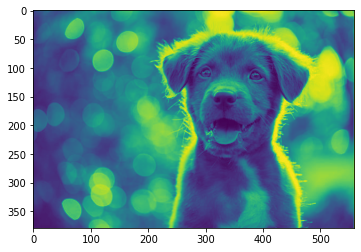

In [5]:
plt.imshow(img)

# 池化操作

In [ ]:
strides = 2
img.shape[0]//strides,img.shape[1]//strides  #磁化整除讲图片大小缩小

In [ ]:
img_new = np.zeros([img.shape[0]//strides,img.shape[1]//strides,img.shape[2]])
img_new1 = np.zeros([img.shape[0]//strides,img.shape[1]//strides,img.shape[2]])

## 平均池化

In [ ]:
%%time
for i in range(0,img.shape[0]//strides*strides,strides):
    for j in range(0,img.shape[1]//strides*strides,strides):## img.shape[1]//strides*strides将不能整除的去掉
        for k in range(img.shape[2]):
            img_new1[i//strides,j//strides,k]=np.average([img[i,j,k],img[i+1,j,k],img[i,j+1,k],img[i+1,j+1,k]])

In [11]:
# 10-27日的代码
# %%time
def pool_mean(img,size=2):
    img_mean = np.zeros([img.shape[0]//size,img.shape[1]//size,img.shape[2]])
    for i in range(0,img.shape[0]//size*size,size):
        for j in range(0,img.shape[1]//size*size,size):
            for k in range(img.shape[2]):
                sum=0
                for m in range(size):
                    for n in range(size):
                        sum+=img[i+m,j+n,k]
                img_mean[i//size,j//size,k] = sum/size/size
    return img_mean

In [12]:
%%time
img_mean = pool_mean(img)

CPU times: user 54 s, sys: 38.4 ms, total: 54.1 s
Wall time: 54.2 s


## 最大池化

In [ ]:

%%time
for i in range(0,img.shape[0]//strides*strides,strides):
    for j in range(0,img.shape[1]//strides*strides,strides):
        for k in range(img.shape[2]):
            img_new[i//strides,j//strides,k]=max([img[i,j,k],img[i+1,j,k],img[i,j+1,k],img[i+1,j+1,k]])

In [13]:
# 10-27日的代码
def pool_max(img,size=2):
    img_max = np.zeros([img.shape[0]//size,img.shape[1]//size,img.shape[2]])
    for i in range(0,img.shape[0]//size*size,size):
        for j in range(0,img.shape[1]//size*size,size):
            for k in range(img.shape[2]):
                maxx = 0
                for m in range(size):
                    for n in range(size):
                        maxx = max(img[i+m,j+n,k],maxx)
                img_max[i//size,j//size,k] = maxx
    return img_max


In [23]:
%%time
img_max = pool_max(img)

CPU times: user 42.3 s, sys: 54 ms, total: 42.3 s
Wall time: 42.4 s


In [24]:
img_mean.shape,img_max.shape,img.shape

((189, 280, 1), (189, 280, 1), TensorShape([379, 560, 1]))

Text(0.5, 1.0, 'original')

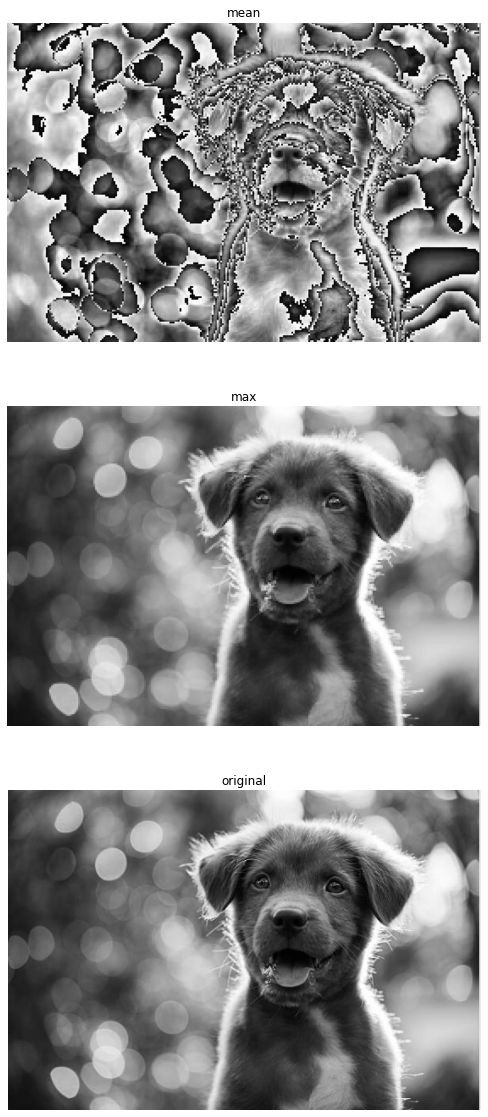

In [32]:
plt.figure(figsize=(15,20))
# fig,ax=plt.subplots(3,1)
# ax[0].figure(figsize=(25,9))
plt.subplot(311)
plt.imshow(img_mean,cmap="gray")
plt.axis('off')
plt.title("mean")

plt.subplot(312)
plt.imshow(img_max,cmap="gray")
plt.axis('off')
plt.title("max")

plt.subplot(313)
plt.imshow(img,cmap="gray")
plt.axis('off')
plt.title("original")

# 卷积操作

In [14]:
def cov33(a,b,c=1,f=3):
    t1 = np.zeros([a.shape[0]-2,a.shape[1]-2,c])
    for i in range(a.shape[0]-2):
        for j in range(a.shape[1]-2):
            for m in range(c):
                for k in range(f):
                    for l in range(f):
                        t1[i,j,m]+=a[i+k,j+l]*b[k,l]
    return t1

In [15]:
def covn33(a,b,c=1,f=3):
    temp = np.zeros([a.shape[0]-2,a.shape[1]-2,img.shape[2]])
    for i in range(a.shape[0]-2):
        for j in range(a.shape[1]-2):
            for k in range(c):
                temp[i,j,k]=np.vdot(a[i:i+f,j:j+f],b)
    return temp

In [16]:
a = img

In [17]:
b1 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

In [18]:
%%time
t1 = covn33(a,b1)

CPU times: user 40.5 s, sys: 23.3 ms, total: 40.6 s
Wall time: 40.7 s


(-0.5, 557.5, 376.5, -0.5)

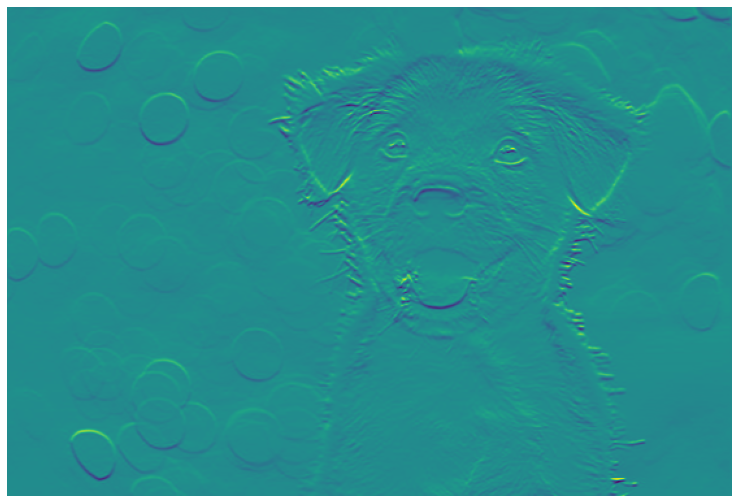

In [19]:
plt.figure(figsize=(25,9))
plt.imshow(t1)
plt.axis("off")